In [28]:
import rospy
import rosbag
from sensor_msgs.msg import PointCloud2
from sensor_msgs import point_cloud2
import numpy as np
import pickle
import matplotlib.pyplot as plt
import struct
from sklearn.cluster import DBSCAN
from nlos_sensing import line_by_2p, intersection_of_2line

In [29]:
file_path = "/home/dingrong/Code/ackermann_car_nav/data/20230613/software3_beichen_2023-06-13-16-49-17"
bag = rosbag.Bag(f"{file_path}.bag")
bag_data = bag.read_messages(topics=['/laser_point_cloud', '/laser_point_cloud2', '/mmwave_radar_point_cloud', '/mmwave_radar_raw_data'])
frame_bytes = 196608

# 提取3种雷达数据
# 我原来想获取同一个时刻下的所有topic，才发现原来各个传感器时间是不一样的，没有任何消息是同时出现的，所以一定有先后时间顺序
# FIXME: 用msg.header.stamp.to_sec进行时间戳对齐不对啊
laser_list, laser_list2, mmwave_list, mmwave_raw_list = [], [], [], []
for topic, msg, t in bag_data:
    if topic == '/laser_point_cloud':
        points = point_cloud2.read_points_list(
            msg, field_names=['x', 'y']
        )
        x_pos = [p.x for p in points]
        y_pos = [p.y for p in points]
        point_cloud = np.array([x_pos, y_pos]).T
        laser_list.append((t.to_sec(), point_cloud))
    if topic == '/laser_point_cloud2':
        points = point_cloud2.read_points_list(
            msg, field_names=['x', 'y']
        )
        x_pos = [p.x for p in points]
        y_pos = [p.y for p in points]
        point_cloud = np.array([x_pos, y_pos]).T
        laser_list2.append((t.to_sec(), point_cloud))
    if topic == '/mmwave_radar_point_cloud':
        points = point_cloud2.read_points_list(
            msg, field_names=['x', 'y', 'z', 'vel', 'snr']
        )
        x_pos = [p.x for p in points]
        y_pos = [p.y for p in points]
        z_pos = [p.z for p in points]
        vel = [p.vel for p in points]
        snr = [p.snr for p in points]
        point_cloud = np.array([x_pos, y_pos, z_pos, vel, snr]).T
        mmwave_list.append((t.to_sec(), point_cloud))
    if topic == '/mmwave_radar_raw_data':
        adc_pack = struct.pack(f">{frame_bytes}b", *msg.data)
        adc_unpack = np.frombuffer(adc_pack, dtype=np.int16)
        mmwave_raw_list.append((t.to_sec(), adc_unpack))

In [30]:
len(mmwave_list), len(mmwave_raw_list), len(laser_list), len(laser_list2)

(2806, 1898, 2807, 2818)

In [31]:
# 时间对齐，方法就是把长的变短
def align_sensors(laser_list, mmwave_list):
    laser_len, mmwave_len = len(laser_list), len(mmwave_list)
    if laser_len < mmwave_len:
        raise Exception("Wrong")
    min_idx, min_v = 0, np.inf
    for i in range(laser_len-mmwave_len+1):
        diff = np.abs(laser_list[i][0] - mmwave_list[0][0])
        if diff < min_v:
            min_v = diff
            min_idx = i
    return laser_list[min_idx:min_idx+mmwave_len], min_v, min_idx

# TODO: 时间戳不对吧，多传感器之间如何同步？或者说，需要同步吗？
mmwave_list, min_v3, min_idx3 = align_sensors(mmwave_list, mmwave_raw_list)
laser_list, min_v1, min_idx1 = align_sensors(laser_list, mmwave_list)
laser_list2, min_v2, min_idx2 = align_sensors(laser_list2, mmwave_list)

In [32]:
min_v1, min_v2, min_v3, min_idx1, min_idx2, min_idx3

(0.037332773208618164, 0.042206525802612305, 1.0778553485870361, 12, 11, 0)

In [33]:
for i in range(len(mmwave_raw_list)):
    print(mmwave_list[i][0], mmwave_raw_list[i][0], laser_list[i][0], laser_list2[i][0])

1686646159.3396828 1686646158.2618275 1686646159.30235 1686646159.2974763
1686646159.4423814 1686646158.3526576 1686646159.4025607 1686646159.3976555
1686646159.5620654 1686646158.4425406 1686646159.502062 1686646159.4975696
1686646159.7348733 1686646158.6546133 1686646159.6077085 1686646159.597417
1686646159.786335 1686646158.689609 1686646159.798675 1686646159.697419
1686646159.8479633 1686646158.7448888 1686646159.845709 1686646159.7969065
1686646159.9380467 1686646158.8911436 1686646159.9082441 1686646159.89646
1686646160.04373 1686646158.9455664 1686646160.0081384 1686646159.9963834
1686646160.141593 1686646159.0399299 1686646160.1081386 1686646160.0961516
1686646160.2379446 1686646159.141413 1686646160.236273 1686646160.1965585
1686646160.444217 1686646159.251643 1686646160.308049 1686646160.2965434
1686646160.4457874 1686646159.33969 1686646160.4091957 1686646160.3965728
1686646160.5406387 1686646159.4423351 1686646160.5111308 1686646160.496161
1686646160.761544 1686646159.62907

In [46]:
# 用laser2提取小车位姿
n_frame = 50
laser_n_frame = np.concatenate([p for t, p in laser_list2[:n_frame]], axis=0)
local_sensing_range = [-1.5, 0, -2.9, -1]  # 切割小车
# local_sensing_range = [-2, 0, -2.9, -2]
flag_x = np.logical_and(laser_n_frame[:, 0]>=local_sensing_range[0], laser_n_frame[:, 0]<=local_sensing_range[1])
flag_y = np.logical_and(laser_n_frame[:, 1]>=local_sensing_range[2], laser_n_frame[:, 1]<=local_sensing_range[3])
flag = np.logical_and(flag_x, flag_y)
laser_part = laser_n_frame[flag]
laser_part.shape

(513, 2)

In [47]:
# 先聚类，提取小车的4条腿的点云，取平均
filter = DBSCAN(eps=0.03, min_samples=5)
db = filter.fit(laser_part)
labels = db.labels_
n_cluster = len(set(labels[labels>-1]))
n_cluster

4

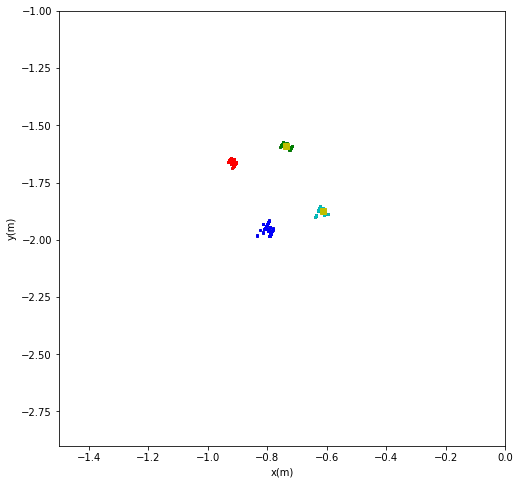

In [49]:
# 可视化小车的四条腿
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlabel('x(m)')
ax.set_ylabel('y(m)')
ax.set_xlim([local_sensing_range[0], local_sensing_range[1]])
ax.set_ylim([local_sensing_range[2], local_sensing_range[3]])
color_panel = ['ro', 'go', 'bo', 'co', 'wo', 'yo', 'mo', 'ko']
ax.plot(laser_part[:, 0], laser_part[:, 1], color_panel[-1], ms=2)

cluster_list = []
for i in range(n_cluster):
    cluster = laser_part[labels==i]
    cluster_list.append(cluster)
    ax.plot(cluster[:, 0], cluster[:, 1], color_panel[i], ms=2)
if n_cluster >= 4:
    # front_right = np.mean(cluster_list[0], axis=0)
    front_right = np.mean(cluster_list[1], axis=0)
    # back_right = np.mean(cluster_list[2], axis=0)
    back_right = np.mean(cluster_list[3], axis=0)
elif n_cluster == 3:
    front_right = np.mean(cluster_list[0], axis=0)
    back_right = np.mean(cluster_list[1], axis=0)
else:
    front_right = np.mean(cluster_list[0], axis=0)
    back_right = np.mean(cluster_list[1], axis=0)
ax.plot(*front_right, 'sy', ms=6)
ax.plot(*back_right, 'sy', ms=6)

In [50]:
# np.linalg.norm(back_right-back_left), 
np.linalg.norm(front_right-back_right)

0.31207963793231824

In [51]:
# 根据两条腿计算旋转角度
coef = line_by_2p(front_right, back_right)
theta = np.arctan(coef[0]) + np.pi if coef[0] < 0 else np.arctan(coef[0])
theta * 180 / np.pi

113.41802611162751

In [52]:
# 计算小车中心点在标定激光雷达坐标系下的位置
k = (front_right[1] - back_right[1]) / (front_right[0] - back_right[0])
l = 0.11
w = 0.105
deltax = l * -np.cos(theta)
deltay = l * np.sin(theta)
x1 = front_right[0] + deltax
y1 = front_right[1] - deltay
coef1 = [-1/k, 1/k*x1+y1]

deltax = w * np.sin(theta)
deltay = w * -np.cos(theta)
x2 = back_right[0] - deltax
y2 = back_right[1] - deltay
coef2 = [k, -k*x2+y2]

inter = intersection_of_2line(coef1, coef2)
inter

array([-0.7892886 , -1.73106995])

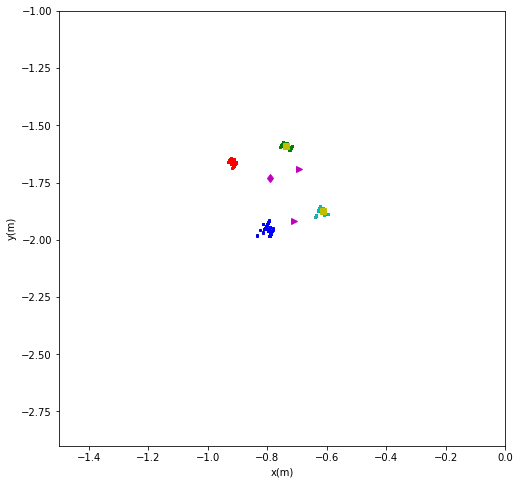

In [53]:
ax.plot(x1, y1, '>m', ms=6)
ax.plot(x2, y2, '>m', ms=6)
ax.plot(*inter, 'dm', ms=6)
fig

In [54]:
# 保存结果：时间、laser、laser2、毫米波点云、毫米波原始数据、小车位姿
transform = (inter, theta)
all_point_cloud = []
for i in range(len(mmwave_list)):
    tmp = (laser_list[i][0], laser_list[i][1], laser_list2[i][1], mmwave_list[i][1], mmwave_raw_list[i][1], transform)
    all_point_cloud.append(tmp)
with open(f"{file_path}.pkl", 'wb') as f:
    pickle.dump(all_point_cloud, f)

In [ ]:
"""收数据，做数据预处理；

x: tensor或点云
    1. RA tensor, 并且我希望只拿出来NLOS那一部分
        基于tensor的做法普遍是把整个tensor作为输入，那基于点云的做法，会挑出来部分点云吗？
    2. 点云，并且我希望只要NLOS的点云

y: 人的bounding box
    还是统一到小车坐标系下吧，这样用tensor作为输入的也好处理；
    统一到小车坐标系下也不对啊，你得统一到雷达坐标系下

怎么获得tensor？原始数据经过fft和music就可以了
怎么获得点云？原始数据经过fft和music后，再经过cfar就可以了
怎么获取bounding box，并统一到雷达坐标系下？
    - 我需要人的点云，从laser2中切分就可以了
    - 我需要墙的坐标，这个从laser的点云中拟合，再变换到laser2下
    - 有了人的点云和墙的坐标，bounding box就有了，可以变换到雷达坐标系下
    - 有了墙的坐标，NLOS的区域、时长也可以知道了，此时可以过滤点云

1. 两个激光雷达通过墙面的激光雷达点云进行配准，也可以获得小车位姿，甚至可能更精确？
2. 我训练模型时，只预测NLOS的结果吗？至少在我的场景中，LOS有激光雷达点云获取人的bounding box了
    但是训练的时候，要不要也对这样的数据进行训练呢？那样的话，我其实把LOS和NLOS看成一样的情况了
3. 直观上想，告诉网络用哪面墙反射也有好处吧


算法流程：
1. laser提取墙面坐标，区分墙面，形成NLOS区域
2. laser2提取人的点云，根据墙面坐标，生成bounding box
3. 处理毫米波雷达原始数据
    - range fft->doppler fft->music, RDA tensor -> CFAR，点云
    - range fft->capon, RA tensor -> CFAR，点云 -> doppler fft

如果对毫米波结果不加区分，那么现在已经做完了，训练样本(毫米波，bounding box)；
但问题是，这样做有很多不是人的点，难道不加过滤地直接作为网络输入？
你先做到这一步就可以了
"""